# PRÁCTICA FINAL

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [70]:
df = pd.read_csv('./Unemployment in America Per US State.csv')
df.head()

,FIPS Code,State/Area,Year,Month,Total Civilian Non-Institutional Population in State/Area,Total Civilian Labor Force in State/Area,Percent (%) of State/Area's Population,Total Employment in State/Area,Percent (%) of Labor Force Employed in State/Area,Total Unemployment in State/Area,Percent (%) of Labor Force Unemployed in State/Area
0,1,Alabama,1976,1,"2,605,000","1,484,555",57.0,"1,386,023",53.2,"98,532",6.6
1,2,Alaska,1976,1,"232,000","160,183",69.0,"148,820",64.1,"11,363",7.1
2,4,Arizona,1976,1,"1,621,000","964,120",59.5,"865,871",53.4,"98,249",10.2
3,5,Arkansas,1976,1,"1,536,000","889,044",57.9,"824,395",53.7,"64,649",7.3
4,6,California,1976,1,"15,621,000","9,774,280",62.6,"8,875,685",56.8,"898,595",9.2


Lo primero que haremos será comprender los datos de los que disponemos. Contamos con 11 variables:


- FIPS Code of State/Area: identificador del Estado
- Year: año
- Month: mes
- Total Civilian Non-Institutional Population in State/Area: Número total de civiles no institucionalizados que residen en el estado/zona.
- Total Civilian Labor Force in State/Area: Número total de civiles aptos para el empleo que residen en el estado/zona.
- Percent (%) of State/Area's Population: Porcentaje de civiles aptos para el empleo sobre el total de la población civil no institucionalizada.
- Total Employment in State/Area: Número total de civiles empleados actualmente en el estado/zona: Porcentaje de civiles actualmente empleados sobre el total de la población civil no institucionalizada.
- Percent (%) of Labor Force Employed in State/Area: Porcentaje de civiles actualmente empleados sobre el total de la población civil no institucionalizada.
- Total Unemployment in State/Area: Número total de civiles actualmente desempleados en el estado/zona.
- Percent (%) of Labor Force Unemployed in State/Area: Porcentaje de civiles actualmente desempleados sobre el total de la población civil no institucionalizada.

## PREPROCESO

Primero comprobamos los tipos de datos que tenemos y la presencia de nulos

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29892 entries, 0 to 29891
Data columns (total 11 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   FIPS Code                                                  29892 non-null  int64  
 1   State/Area                                                 29892 non-null  object 
 2   Year                                                       29892 non-null  int64  
 3   Month                                                      29892 non-null  int64  
 4   Total Civilian Non-Institutional Population in State/Area  29892 non-null  object 
 5   Total Civilian Labor Force in State/Area                   29892 non-null  object 
 6   Percent (%) of State/Area's Population                     29892 non-null  float64
 7   Total Employment in State/Area                             29892 non-null  object 
 8   Percen

Observamos que todas las estadísticas civiles se almacenan con un tipo de dato objeto. Necesitamos convertirlas a un tipo de dato numérico para poder trabajar con ellas:

In [72]:
def objToInt(col):
    if df.dtypes[i]!='int64' and df.dtypes[i]!='float64':
        df[col]=df[col].str.replace(',','').astype(int)

In [73]:
columns = df.columns
for i in range(2,len(columns)):
    objToInt(columns[i])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29892 entries, 0 to 29891
Data columns (total 11 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   FIPS Code                                                  29892 non-null  int64  
 1   State/Area                                                 29892 non-null  object 
 2   Year                                                       29892 non-null  int64  
 3   Month                                                      29892 non-null  int64  
 4   Total Civilian Non-Institutional Population in State/Area  29892 non-null  int64  
 5   Total Civilian Labor Force in State/Area                   29892 non-null  int64  
 6   Percent (%) of State/Area's Population                     29892 non-null  float64
 7   Total Employment in State/Area                             29892 non-null  int64  
 8   Percen

Para poder trabajar de mejor forma con las series temporales, creamos una columna con la fecha (en formato año/mes/día) combinando el mes y el año, para tener una marca de tiempo en una única columna:

In [74]:
df['Date']=pd.to_datetime(df['Year']*100 + df['Month'] ,format='%Y%m')
# df.drop(columns=['Year','Month'],inplace=True)
df.head()

,FIPS Code,State/Area,Year,Month,Total Civilian Non-Institutional Population in State/Area,Total Civilian Labor Force in State/Area,Percent (%) of State/Area's Population,Total Employment in State/Area,Percent (%) of Labor Force Employed in State/Area,Total Unemployment in State/Area,Percent (%) of Labor Force Unemployed in State/Area,Date
0,1,Alabama,1976,1,2605000,1484555,57.0,1386023,53.2,98532,6.6,1976-01-01
1,2,Alaska,1976,1,232000,160183,69.0,148820,64.1,11363,7.1,1976-01-01
2,4,Arizona,1976,1,1621000,964120,59.5,865871,53.4,98249,10.2,1976-01-01
3,5,Arkansas,1976,1,1536000,889044,57.9,824395,53.7,64649,7.3,1976-01-01
4,6,California,1976,1,15621000,9774280,62.6,8875685,56.8,898595,9.2,1976-01-01


In [75]:
def extraer_serie_temporal(df,estado):
    if estado != 'USA':
        serie_temporal = df[df['State/Area']==estado]
        desempleo = serie_temporal['Total Unemployment in State/Area'].values*100
        poblacion = serie_temporal['Total Civilian Labor Force in State/Area'].values
        serie_temporal[str('% Desempleo en '+ estado)] = desempleo/poblacion

        sns.set(style='whitegrid')
        sns.lineplot(x = "Date",
                y = str('% Desempleo en '+ estado),
                data = serie_temporal)

        return serie_temporal
    else:
        desempleo=pd.DataFrame(df.groupby('Date')[["Total Unemployment in State/Area"]].sum())
        poblacion=pd.DataFrame(df.groupby('Date')[["Total Civilian Labor Force in State/Area"]].sum())

        desempleo.reset_index(inplace=True)
        poblacion.reset_index(inplace=True)

        desempleo['Total Unemployment in State/Area']*=100

        serie_temporal=pd.DataFrame()
        serie_temporal['Date'] = df['Date'].unique()
        serie_temporal['% Unemployment in US'] = desempleo['Total Unemployment in State/Area']/poblacion["Total Civilian Labor Force in State/Area"]
        sns.set(style='whitegrid')

        sns.lineplot(x = "Date",
             y = "% Unemployment in US",
             data = serie_temporal)
        return serie_temporal

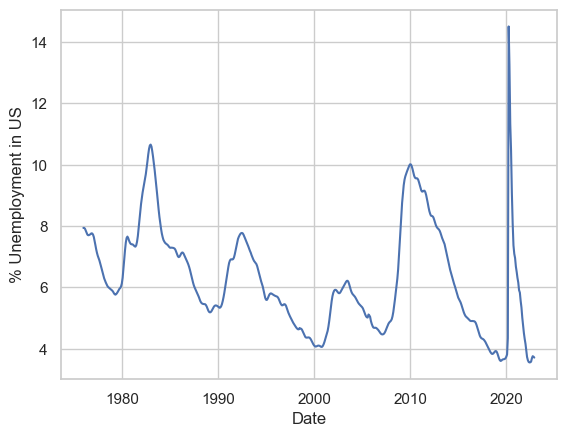

In [76]:
serie_temporal = extraer_serie_temporal(df, 'USA')

En el apartado anterior, hemos analizado el **Porcentaje de la Fuerza Laboral total de los Estados Unidos que está desempleada en cada mes**. Hacemos esto sumando el Total de Desempleo para cada estado y dividiendo eso por la suma del Total de la Fuerza Laboral Civil en todos los estados.

Posteriormente , generamos un gráfico que nos intente proporcionar algún tipo de descubrimiento en este caso tendencias en el desempleo.

Tras la generación anterior, no resaltamos ninguna tendencia en el desempleo, no se encuentra a priori estacionalidad, sin embargo descubrimos altos picos entorno a los años 1982, 2010 y 2020. Por ello, representamos gráficamente los 10 meses con un porcentaje más alto de desempleo en los EEUU de todos los tiempos.

In [77]:
top = serie_temporal.sort_values(by = '% Unemployment in US', ascending = False)[:10]
bottom = serie_temporal.sort_values(by = '% Unemployment in US', ascending = False)[-9:]
top

,Date,% Unemployment in US
531,2020-04-01,14.512050
532,2020-05-01,13.262448
533,2020-06-01,11.335550
84,1983-01-01,10.658533
83,1982-12-01,10.631486
85,1983-02-01,10.596150
82,1982-11-01,10.521718
534,2020-07-01,10.471440
86,1983-03-01,10.454415
81,1982-10-01,10.336860


[Text(0, 0, '2020-04'),
 Text(1, 0, '2020-05'),
 Text(2, 0, '2020-06'),
 Text(3, 0, '1983-01'),
 Text(4, 0, '1982-12'),
 Text(5, 0, '1983-02'),
 Text(6, 0, '1982-11'),
 Text(7, 0, '2020-07'),
 Text(8, 0, '1983-03'),
 Text(9, 0, '1982-10')]

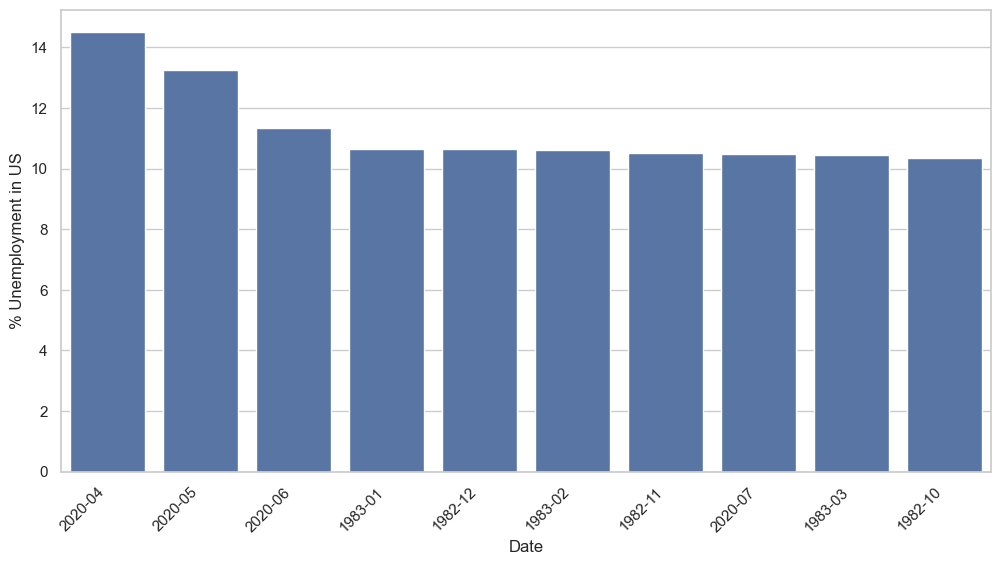

In [78]:
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x = "Date", y = "% Unemployment in US", data = top, 
                  ax=ax)

x_dates = top['Date'].dt.strftime('%Y-%m')
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')


Tras la representación, no es algo sorprendente, puesto que hemos determinado en esencia que las tasas de desempleo más altas corresponden al año 2020.

Tras darnos cuenta que es algo lógico, puesto que fue la era del Covid-19. La propagación inicial de la enfermendad suposo el despido masivo, ya que muchas empresas se vieron afectadas y encontraron grandes dificultades para desarrollar sus servicios u operaciones.


Para ello, pensamos en qué estados fueron los más afectados durante el periodo comprendido y poder llevar a cabo políticas que nos permitan cómo mejorar en un futuro estas grandes tasas de desempleo.

*ÉPOCA DEL COVID-19*

Para abordar esta situación, hemos considerado generar un nuevo dataframe, que contiene las tasas mensuales de desempleo desde abril hasta julio de 2020 para cada uno de los estados o áreas.

El parámetro *date* determinará el valor de la fecha para cual deseamos obtener las tasas de desempleo, por lo que almacenamos estas tasas en una columna denotada como *newMonth*.

In [79]:
covid_data = pd.DataFrame()
covid_data['States']=df['State/Area'].unique()

def addMonth(date, colname):
    newMonth = pd.DataFrame(df.loc[df['Date']==date,'Percent (%) of Labor Force Unemployed in State/Area'])
    newMonth.reset_index(inplace = True, drop = True)
    covid_data[colname] = newMonth

In [80]:
date = ['2020-04-01','2020-05-01','2020-06-01','2020-07-01']
months = ['April','May','June','July']
for i in range(4):
    addMonth(date[i],months[i])
covid_data.head()

,States,April,May,June,July
0,Alabama,13.8,10.4,8.6,7.5
1,Alaska,11.8,11.9,11.4,11.3
2,Arizona,13.8,11.2,9.7,8.9
3,Arkansas,10.1,8.9,7.9,7.3
4,California,16.1,15.7,13.8,13.2


Una vez obtenemos el nuevo conjunto de datos, podemos realizar una función que nos permita llevar a cabo el estudio de cuáles son los principales estados que han sufrido un mayor tasa de desempleo.

Mostramos los 10 primeros más afectados.

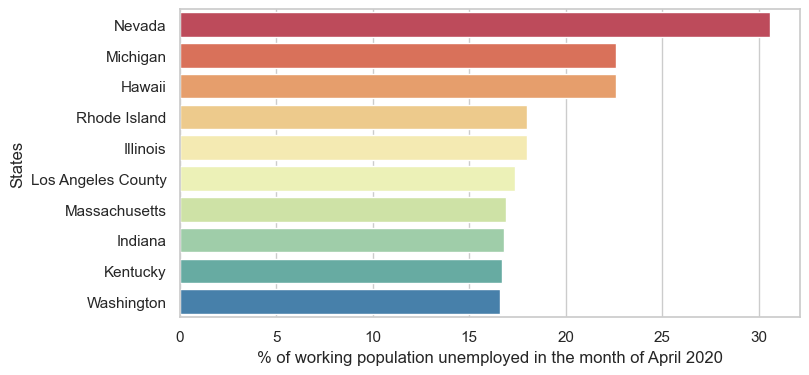

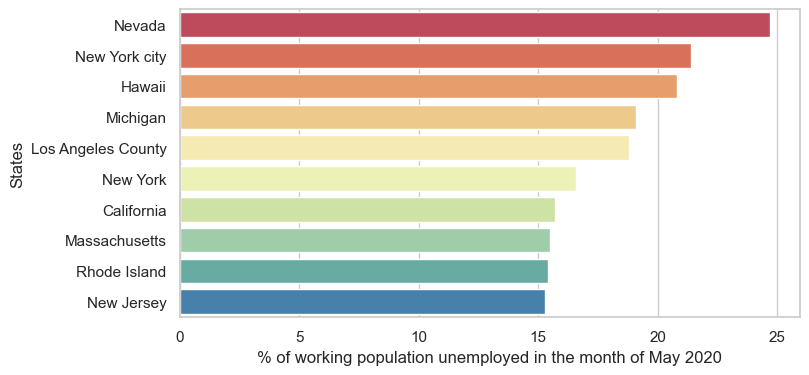

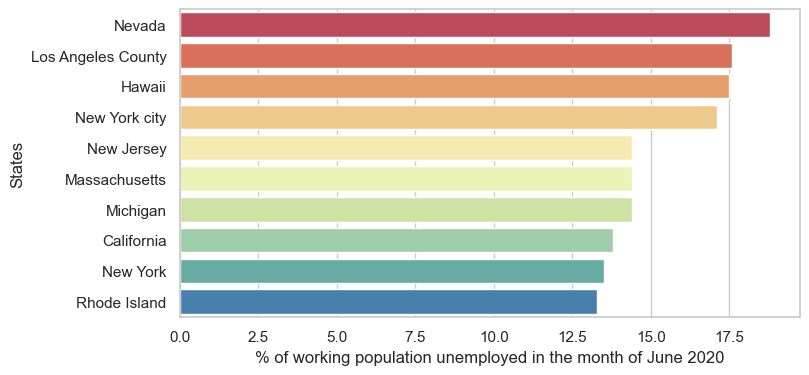

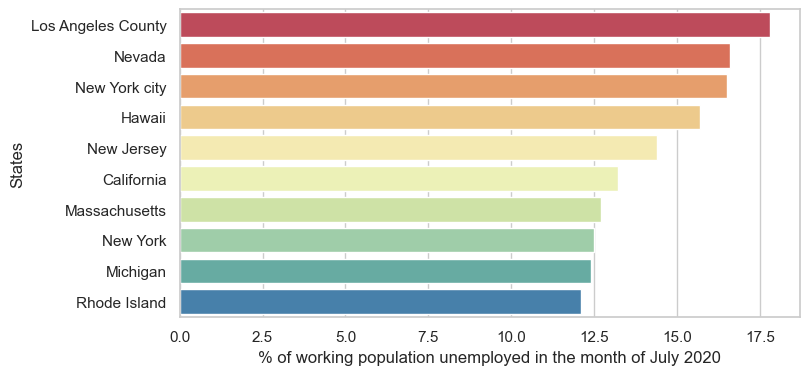

In [83]:
def monthPlot(month):
    plt.figure(figsize = (8,4))    
    fig = sns.barplot(y = "States", 
                      x = month, 
                      data = covid_data, 
                      order = covid_data.sort_values(by = month, ascending = False).States.head(10),
                      orient = 'h',
                      palette = ('Spectral'))
    fig.set(xlabel = str('% of working population unemployed in the month of ' + month + ' 2020'))
for i in range(4):
    monthPlot(months[i])


Podemos descubrir algo de conocimiento:
- El estado de Nevada parece ser el más afectado de manera global de todos los estados, sufriendo el mayor % de desempleo, de manera general.

- Vemos como Los Angeles Country, al principio comienza con un porcentaje menor % , colocándose a finales de esta etapa como el estado con mayor % de desempleo , lo que podría conllevar a que el número de casos de la enfermedad y el avance de la misma en ese estado haya sido peor que en el resto, lo que podríamos determinar en esencia como mejorar la situación de la enfermedad y así tratar de paliar el desempleo en la ciudad.

Podemos observar que estos estados, cuyas tasas de desempleo eran mayor al 10% , tienen una fracción considerable de civiles que estaban desempleados, y por ello vamos a ver cuánto contribuyeron estos estaados al nº TOTAL de civiles desempleados en el país durante los meses dados. El propósito de ello, puede ser llevar a cabo el establecimiento de fondos o recursos basados en necesidades, es decir, cómo repartir la economía general del país en aquellos estados cuya situación sea peor que en el resto.

Para ello crearemos una función que calcule la suma total de los desempleados en un mes dado, los nombre de los 10 estados con tasas de desempleo más altas , la suma total de civiles para esos 10 estados y el porcentaje de ciudadnos desempleados en EEUU que proviene de los 10 estados con las tasas de desempleo más elevadas.

In [86]:
def fracTop(date,month):
    temp = int(df.loc[df['Date']== date][['Total Unemployment in State/Area']].sum())
    sort = list(covid_data.sort_values(by = month, ascending = False).States.head(10))
    unemp_top=int(df.loc[(df['Date']==date) & (df['State/Area'].isin(sort))][['Total Unemployment in State/Area']].sum())
    var = unemp_top*100/temp
    
    #Plotting a pie chart
    
    explode = [0,0.1]
    keys = ['Remaining States','Top 10 States with highest Unemployment Rate']
    data = [100-var,var]
    color = sns.color_palette('dark')
    
    plt.pie(data, 
            labels = keys, 
            colors = color, 
            explode = explode, 
            autopct='%.02f%%')
    
    plt.title(str('Share of Unemployed Civilians in the US for the month of '+ month +' 2020:'))
    plt.show()
      
    
    print("The top 10 states make up " + "{:.2f}".format(var) + " percent of all unemployed civilians in the US Labor Force in the month of "+ month +" 2020\n\n\n\n")


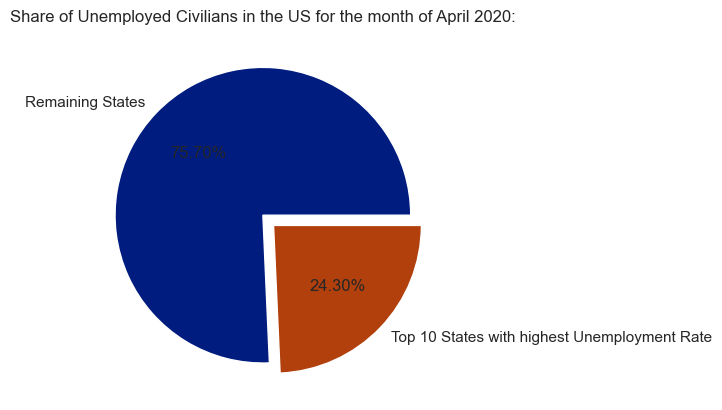

The top 10 states make up 24.30 percent of all unemployed civilians in the US Labor Force in the month of April 2020






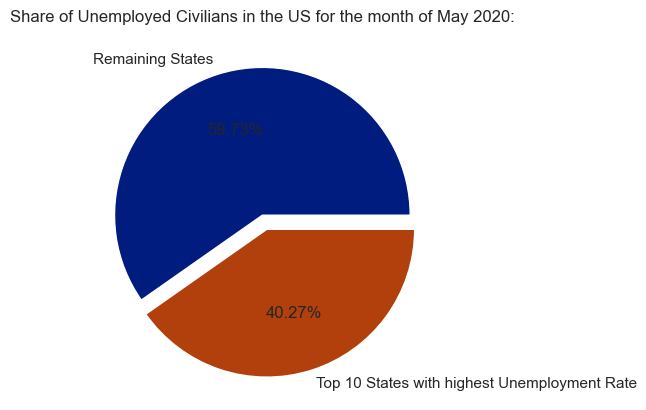

The top 10 states make up 40.27 percent of all unemployed civilians in the US Labor Force in the month of May 2020






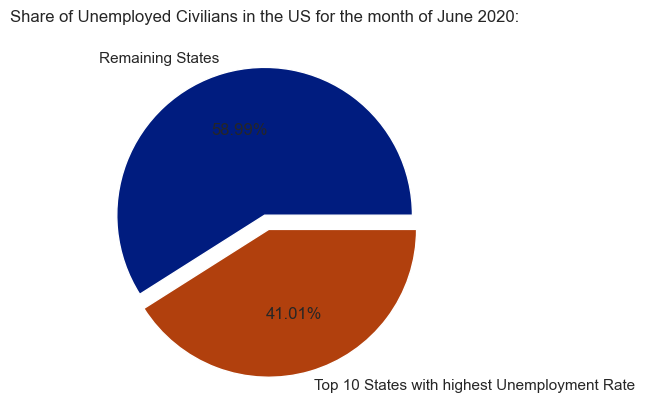

The top 10 states make up 41.01 percent of all unemployed civilians in the US Labor Force in the month of June 2020






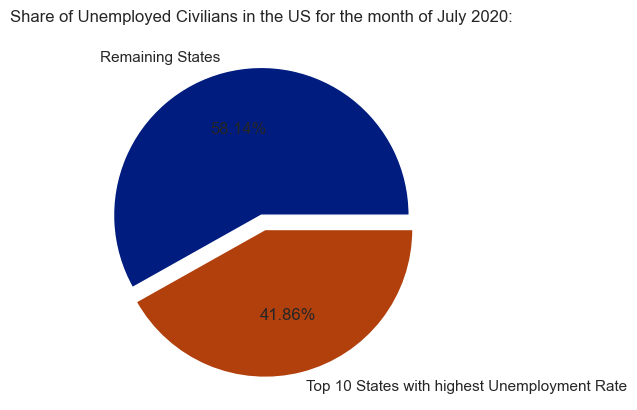

The top 10 states make up 41.86 percent of all unemployed civilians in the US Labor Force in the month of July 2020






In [87]:
for i in range(len(date)):
    fracTop(date[i],months[i])

Resulta notable que, a pesar de que en abril de 2020 se registraron algunas de las tasas de desempleo más elevadas a nivel estatal, los 10 estados principales tienen una participación mínima en el número total de civiles desempleados en los Estados Unidos durante esos cuatro meses. Contribuyen apenas con una cuarta parte del total de civiles desempleados, mientras que en los meses subsiguientes representan más del 40% del total. Esta discrepancia podría atribuirse al hecho de que dos áreas densamente pobladas, concretamente Nueva York y California, ingresaron al top 10 a partir de mayo.